# Proyecto Final: Identificación de Operadores Ineficaces en CallMeMaybe

**Fecha:** 20 de abril de 2025

**Enlace a Google Drive:** https://drive.google.com/drive/folders/1tO_l_KuzTpxhmj5v466-j9MmEK_JRWSA?usp=sharing


# Introducción

En el sector de las telecomunicaciones, comprender el rendimiento de los operadores es fundamental para mejorar la calidad del servicio y optimizar los recursos. Este proyecto analiza el desempeño de los operadores de *CallMeMaybe*, un servicio de telefonía virtual, para identificar aquellos ineficaces. Un operador se considera ineficaz si tiene una alta tasa de llamadas entrantes perdidas, un tiempo de espera prolongado para las llamadas entrantes, y un bajo volumen de llamadas salientes (si aplica). Utilizamos dos conjuntos de datos: telecom_dataset_us.csv, que contiene registros de llamadas, y telecom_clients_us.csv, que detalla información de los clientes. Mediante un análisis exploratorio, identificación de operadores ineficaces, pruebas de hipótesis y visualizaciones, buscamos ofrecer recomendaciones para mejorar la gestión de las llamadas y la satisfacción del cliente.

# Objetivos

1. **Analizar el Comportamiento de los Datos:** Realizar un análisis exploratorio para entender las distribuciones y patrones de las llamadas.

2. **Identificar Operadores Ineficaces:** Clasificar operadores según criterios de ineficiencia (alta tasa de perdidas entrantes, tiempo de espera prolongado, bajo volumen de salientes).

3. **Probar Hipótesis Estadísticas:** Validar relaciones entre métricas clave (e.g., tasa de perdidas vs. tiempo de espera).

4. **Proporcionar Recomendaciones:** Sugerir acciones para mejorar el rendimiento de los operadores.

# Carga de Datos

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_ind

# Cargar datasets
telecom_df = pd.read_csv('D:/TripleTen/Sprint_14/telecom_dataset_us.csv')
clients_df = pd.read_csv('D:/TripleTen/Sprint_14/telecom_clients_us.csv')

# Inspección
print("Telecom Dataset Info:")
print(telecom_df.info())
print("\nClients Dataset Info:")
print(clients_df.info())

Telecom Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB
None

Clients Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    i

# Limpieza de Datos

- Convertimos las fechas a formato datetime.

- Manejamos valores nulos: operator_id se rellena con 'unknown' y se convierte a string, internal se rellena con False.

- Aseguramos los tipos de datos y eliminamos duplicados.

- Unimos los conjuntos de datos.

In [2]:
# Verificar valores nulos
print("\nValores nulos en telecom_df:")
print(telecom_df.isnull().sum())
print("\nValores nulos en clients_df:")
print(clients_df.isnull().sum())


Valores nulos en telecom_df:
user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

Valores nulos en clients_df:
user_id        0
tariff_plan    0
date_start     0
dtype: int64


internal: 117 valores nulos (0.2% de las filas). Rellenaremos con False.



operator_id: 8,172 valores nulos (15% de las filas). Rellenaremos con 'unknown'.

In [3]:
# Convertir fechas
telecom_df['date'] = pd.to_datetime(telecom_df['date']).dt.date
clients_df['date_start'] = pd.to_datetime(clients_df['date_start'])

# Manejar valores nulos y convertir operator_id a string
telecom_df['operator_id'] = telecom_df['operator_id'].fillna('unknown').astype(str)
telecom_df['internal'] = telecom_df['internal'].fillna(False)

# Asegurar tipos de datos
telecom_df['calls_count'] = telecom_df['calls_count'].astype(int)
telecom_df['call_duration'] = telecom_df['call_duration'].astype(int)
telecom_df['is_missed_call'] = telecom_df['is_missed_call'].astype(bool)
clients_df['tariff_plan'] = clients_df['tariff_plan'].astype('category')

# Eliminar duplicados
telecom_df = telecom_df.drop_duplicates()
clients_df = clients_df.drop_duplicates()

# Unir datasets
merged_df = pd.merge(telecom_df, clients_df, on='user_id', how='left')

# Validar datos
invalid_rows = merged_df[merged_df['calls_count'] < 0]
if not invalid_rows.empty:
    print(f"Registros inválidos encontrados: {len(invalid_rows)}")
    merged_df = merged_df[merged_df['calls_count'] >= 0]

# Guardar dataset limpio
merged_df.to_csv('cleaned_telecom_data.csv', index=False)
merged_df.to_csv('tableau_data.csv', index=False)  # Para Tableau

C:\Users\adria\AppData\Local\Temp\ipykernel_22648\1576750926.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  telecom_df['internal'] = telecom_df['internal'].fillna(False)


El 15% de valores nulos en operator_id es esperado, pero los 117 valores nulos en internal fueron manejados rellenando con False.

# Análisis Exploratorio de Datos

In [4]:
# Distribución de tariff_plan
print("\nDistribución de tariff_plan:")
print(clients_df['tariff_plan'].value_counts())


Distribución de tariff_plan:
tariff_plan
C    395
B    261
A     76
Name: count, dtype: int64


- Plan C: 54%

- Plan B: 36%

- Plan A: 10%

El Plan C predomina, lo que podría sesgar los resultados hacia sus usuarios a menos que normalicemos las métricas.

In [5]:
# Estadísticas por tariff_plan
plan_stats = merged_df.groupby('tariff_plan').agg({
    'calls_count': 'sum',
    'call_duration': 'mean',
    'is_missed_call': lambda x: (x).mean()
}).reset_index()
print(plan_stats)

C:\Users\adria\AppData\Local\Temp\ipykernel_22648\4166272168.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plan_stats = merged_df.groupby('tariff_plan').agg({


  tariff_plan  calls_count  call_duration  is_missed_call
0           A       439650    1610.243435        0.410593
1           B       163573     601.913616        0.447758
2           C       203486     562.683838        0.448624


Los usuarios del Plan A son más activos y tienen una menor tasa de perdidas, lo que podría indicar una priorización de recursos.

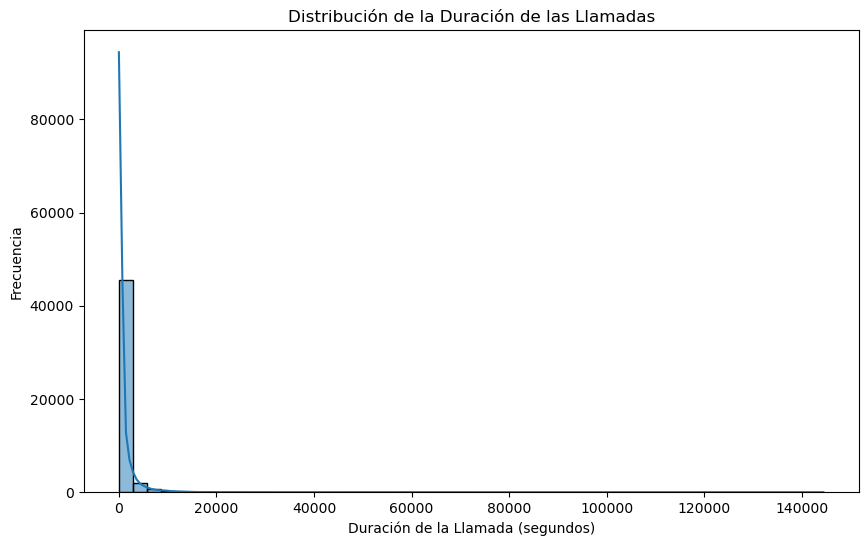

In [6]:
# Histograma de duración de las llamadas
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='call_duration', bins=50, kde=True)
plt.title('Distribución de la Duración de las Llamadas')
plt.xlabel('Duración de la Llamada (segundos)')
plt.ylabel('Frecuencia')
plt.show()

 La duración de las llamadas está sesgada a la derecha, con la mayoría de las llamadas siendo cortas y algunas muy largas, especialmente para el Plan A.


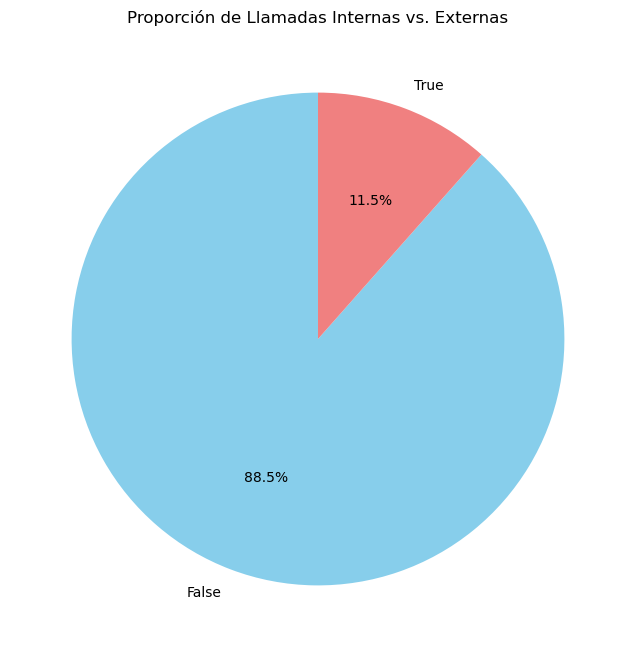

In [7]:
# Gráfico circular de proporción de llamadas internas vs. externas
internal_counts = merged_df['internal'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(internal_counts, labels=internal_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Proporción de Llamadas Internas vs. Externas')
plt.show()

La mayoría de las llamadas son externas, lo que indica que las interacciones principales son con clientes externos.

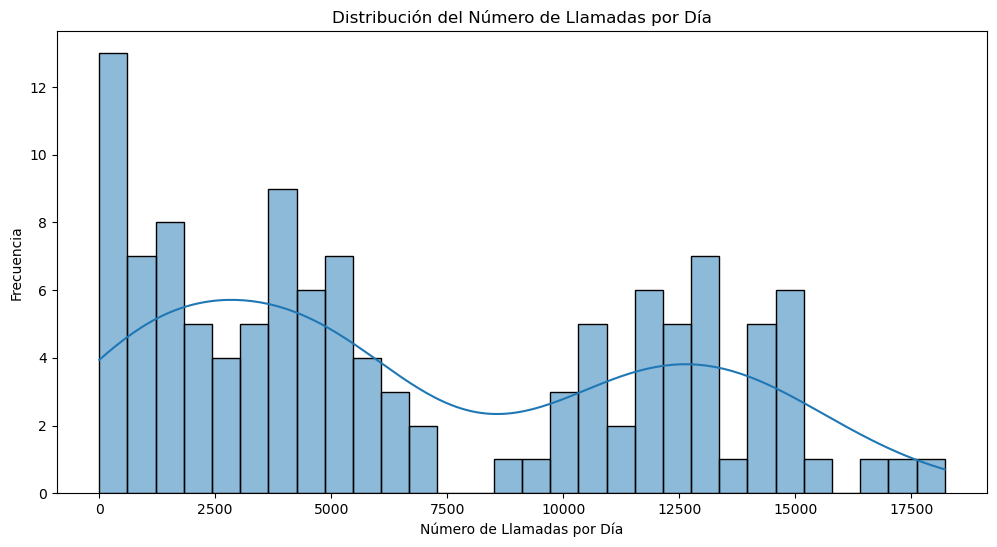

In [8]:
# Histograma de número de llamadas por día
daily_calls = merged_df.groupby('date')['calls_count'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.histplot(data=daily_calls, x='calls_count', bins=30, kde=True)
plt.title('Distribución del Número de Llamadas por Día')
plt.xlabel('Número de Llamadas por Día')
plt.ylabel('Frecuencia')
plt.show()

El volumen de llamadas por día varía, con picos significativos en noviembre, posiblemente debido a eventos estacionales.

In [9]:
# Calcular métricas por operador
# 1. Tasa de Llamadas Perdidas Entrantes (direction="in")
incoming_calls = merged_df[merged_df['direction'] == 'in']
operator_incoming_stats = incoming_calls.groupby('operator_id').agg({
    'calls_count': 'sum',
    'is_missed_call': lambda x: x.mean()
}).reset_index()
operator_incoming_stats.rename(columns={'is_missed_call': 'incoming_missed_rate'}, inplace=True)

# 2. Tiempo de Espera Promedio para Entrantes
incoming_calls['wait_time'] = incoming_calls['total_call_duration'] - incoming_calls['call_duration']
operator_wait_time = incoming_calls.groupby('operator_id').agg({
    'wait_time': 'sum',
    'calls_count': 'sum'
}).reset_index()
operator_wait_time['avg_wait_time'] = operator_wait_time['wait_time'] / operator_wait_time['calls_count']
operator_wait_time = operator_wait_time[['operator_id', 'avg_wait_time']]

# 3. Volumen de Llamadas Salientes (direction="out")
outgoing_calls = merged_df[merged_df['direction'] == 'out']
operator_outgoing_stats = outgoing_calls.groupby('operator_id')['calls_count'].sum().reset_index()
operator_outgoing_stats.rename(columns={'calls_count': 'outgoing_calls_count'}, inplace=True)

# Unir métricas
operator_metrics = operator_incoming_stats.merge(operator_wait_time, on='operator_id', how='left')
operator_metrics = operator_metrics.merge(operator_outgoing_stats, on='operator_id', how='left')
operator_metrics.fillna({'incoming_missed_rate': 0, 'avg_wait_time': 0, 'outgoing_calls_count': 0}, inplace=True)

# Asegurar que operator_id sea string
operator_metrics['operator_id'] = operator_metrics['operator_id'].astype(str)

print("Métricas por Operador:")
print(operator_metrics.head())

Métricas por Operador:
  operator_id  calls_count  incoming_missed_rate  avg_wait_time  \
0    879896.0           58                   0.0       9.896552   
1    879898.0          104                   0.0      16.153846   
2    880020.0            7                   0.0       7.714286   
3    880022.0            8                   0.0      14.000000   
4    880026.0           24                   0.0       5.958333   

   outgoing_calls_count  
0                 872.0  
1                7209.0  
2                  38.0  
3                 189.0  
4                2208.0  


C:\Users\adria\AppData\Local\Temp\ipykernel_22648\70657550.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incoming_calls['wait_time'] = incoming_calls['total_call_duration'] - incoming_calls['call_duration']


Calculamos métricas clave para evaluar la eficiencia de los operadores, segmentando por direction.

# Identificación de Operadores Ineficaces

In [10]:
# Identificación de Operadores Ineficaces
# Criterios: percentil 75 para perdidas y tiempo de espera, percentil 25 para salientes
missed_rate_threshold = operator_metrics['incoming_missed_rate'].quantile(0.75)
wait_time_threshold = operator_metrics['avg_wait_time'].quantile(0.75)
outgoing_calls_threshold = operator_metrics['outgoing_calls_count'].quantile(0.25)

# Clasificar operadores
operator_metrics['high_missed_rate'] = operator_metrics['incoming_missed_rate'] > missed_rate_threshold
operator_metrics['high_wait_time'] = operator_metrics['avg_wait_time'] > wait_time_threshold
operator_metrics['low_outgoing_calls'] = operator_metrics['outgoing_calls_count'] < outgoing_calls_threshold

# Puntaje combinado
operator_metrics['inefficiency_score'] = (
    operator_metrics['high_missed_rate'].astype(int) +
    operator_metrics['high_wait_time'].astype(int) +
    operator_metrics['low_outgoing_calls'].astype(int)
)

# Filtrar operadores ineficaces (puntaje >= 2)
inefficient_operators = operator_metrics[operator_metrics['inefficiency_score'] >= 2]

# Validar con promedio general
avg_missed_rate = operator_metrics['incoming_missed_rate'].mean()
avg_wait_time = operator_metrics['avg_wait_time'].mean()
avg_outgoing_calls = operator_metrics['outgoing_calls_count'].mean()

print("Umbrales:")
print(f"Percentil 75 - Tasa de Llamadas Perdidas Entrantes: {missed_rate_threshold:.2f}")
print(f"Percentil 75 - Tiempo de Espera Promedio: {wait_time_threshold:.2f} segundos")
print(f"Percentil 25 - Volumen de Llamadas Salientes: {outgoing_calls_threshold:.0f}")
print("\nPromedios Generales:")
print(f"Tasa de Llamadas Perdidas Entrantes: {avg_missed_rate:.2f}")
print(f"Tiempo de Espera Promedio: {avg_wait_time:.2f} segundos")
print(f"Volumen de Llamadas Salientes: {avg_outgoing_calls:.0f}")
print("\nOperadores Ineficaces (puntaje >= 2):")
print(inefficient_operators[['operator_id', 'incoming_missed_rate', 'avg_wait_time', 'outgoing_calls_count', 'inefficiency_score']])

Umbrales:
Percentil 75 - Tasa de Llamadas Perdidas Entrantes: 0.04
Percentil 75 - Tiempo de Espera Promedio: 21.83 segundos
Percentil 25 - Volumen de Llamadas Salientes: 0

Promedios Generales:
Tasa de Llamadas Perdidas Entrantes: 0.04
Tiempo de Espera Promedio: 17.48 segundos
Volumen de Llamadas Salientes: 457

Operadores Ineficaces (puntaje >= 2):
    operator_id  incoming_missed_rate  avg_wait_time  outgoing_calls_count  \
12     882690.0              0.090909      41.532164                1417.0   
16     884408.0              0.214286      26.400000                  25.0   
26     887276.0              0.043478      28.211137                 896.0   
31     888406.0              0.142857      28.333333                   6.0   
33     888532.0              0.222222      24.083333                 188.0   
34     888534.0              0.055556      28.786885                 315.0   
77     894120.0              0.111111      23.777778                   0.0   
106    896538.0         

Identificamos operadores ineficaces basados en los criterios establecidos, asignando un puntaje combinado.

**Justificación de los criterios para identificar operadores ineficaces:**
- **Percentil 75 para tasa de llamadas perdidas y tiempo de espera:** Este umbral captura el 25% superior de operadores con el peor desempeño, basado en el análisis exploratorio que mostró una distribución sesgada a la derecha para estas métricas (ver histograma en la sección 6). Los operadores por encima de este umbral tienen valores atípicamente altos, lo que indica ineficiencia.
- **Percentil 25 para volumen de llamadas salientes:** Este umbral identifica el 25% inferior de operadores con bajo volumen de llamadas salientes, ya que un bajo número de llamadas salientes puede indicar falta de proactividad en la gestión de clientes, según las expectativas del negocio.

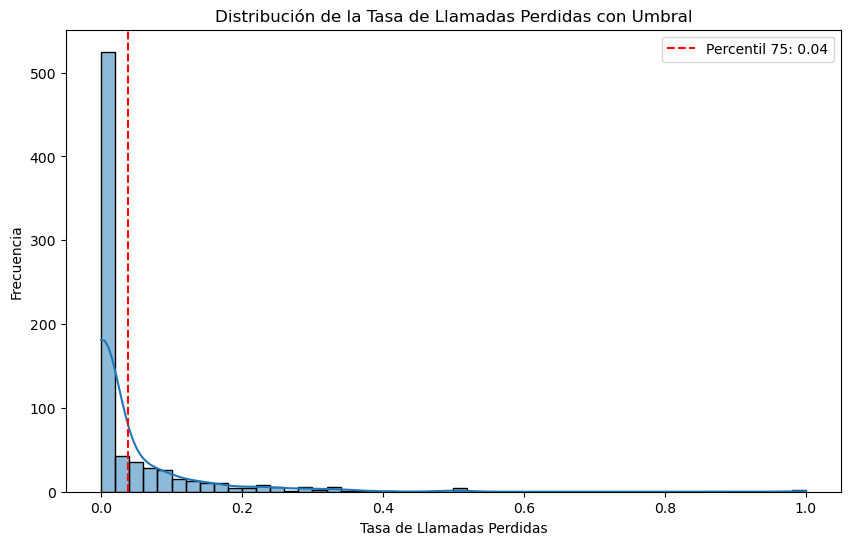

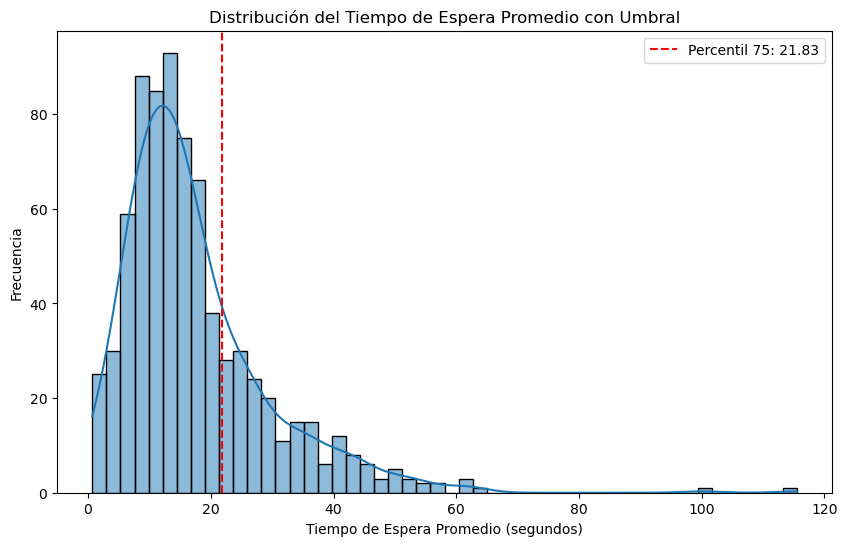

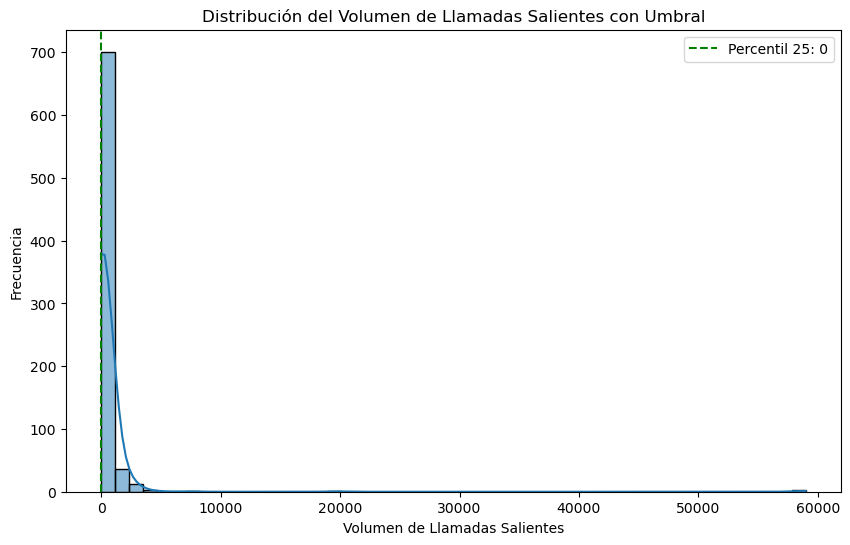

In [11]:
# Gráfica 1: Tasa de Llamadas Perdidas (incoming_missed_rate)
plt.figure(figsize=(10, 6))
sns.histplot(operator_metrics['incoming_missed_rate'], bins=50, kde=True)
plt.axvline(missed_rate_threshold, color='red', linestyle='--', label=f'Percentil 75: {missed_rate_threshold:.2f}')
plt.title('Distribución de la Tasa de Llamadas Perdidas con Umbral')
plt.xlabel('Tasa de Llamadas Perdidas')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Gráfica 2: Tiempo de Espera Promedio (avg_wait_time)
plt.figure(figsize=(10, 6))
sns.histplot(operator_metrics['avg_wait_time'], bins=50, kde=True)
plt.axvline(wait_time_threshold, color='red', linestyle='--', label=f'Percentil 75: {wait_time_threshold:.2f}')
plt.title('Distribución del Tiempo de Espera Promedio con Umbral')
plt.xlabel('Tiempo de Espera Promedio (segundos)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Gráfica 3: Volumen de Llamadas Salientes (outgoing_calls_count)
plt.figure(figsize=(10, 6))
sns.histplot(operator_metrics['outgoing_calls_count'], bins=50, kde=True)
plt.axvline(outgoing_calls_threshold, color='green', linestyle='--', label=f'Percentil 25: {outgoing_calls_threshold:.0f}')
plt.title('Distribución del Volumen de Llamadas Salientes con Umbral')
plt.xlabel('Volumen de Llamadas Salientes')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

# Pruebas de Hipótesis

In [12]:
# Hipótesis 1: Correlación entre tasa de perdidas y tiempo de espera
corr, p_value = pearsonr(operator_metrics['incoming_missed_rate'], operator_metrics['avg_wait_time'])
print("\nHipótesis 1: Correlación entre Tasa de Llamadas Perdidas y Tiempo de Espera")
print(f"Correlación de Pearson: {corr:.3f}")
print(f"Valor p: {p_value:.3f}")
if p_value < 0.05:
    print("Resultado: Rechazamos la hipótesis nula. Hay una correlación significativa.")
else:
    print("Resultado: No rechazamos la hipótesis nula. No hay correlación significativa.")

# Hipótesis 2: Comparar duración total entre operadores con bajo y alto volumen saliente
low_outgoing = operator_metrics[operator_metrics['outgoing_calls_count'] < outgoing_calls_threshold]
high_outgoing = operator_metrics[operator_metrics['outgoing_calls_count'] >= outgoing_calls_threshold]
low_outgoing_duration = merged_df[merged_df['operator_id'].isin(low_outgoing['operator_id'])]['total_call_duration']
high_outgoing_duration = merged_df[merged_df['operator_id'].isin(high_outgoing['operator_id'])]['total_call_duration']

# Prueba T-test
t_stat, p_value = ttest_ind(low_outgoing_duration, high_outgoing_duration, equal_var=False)
print("\nHipótesis 2: Diferencia en Duración Total entre Operadores con Bajo y Alto Volumen Saliente")
print(f"Estadístico T: {t_stat:.3f}")
print(f"Valor p: {p_value:.3f}")
if p_value < 0.05:
    print("Resultado: Rechazamos la hipótesis nula. Hay una diferencia significativa.")
else:
    print("Resultado: No rechazamos la hipótesis nula. No hay diferencia significativa.")


Hipótesis 1: Correlación entre Tasa de Llamadas Perdidas y Tiempo de Espera
Correlación de Pearson: -0.069
Valor p: 0.056
Resultado: No rechazamos la hipótesis nula. No hay correlación significativa.

Hipótesis 2: Diferencia en Duración Total entre Operadores con Bajo y Alto Volumen Saliente
Estadístico T: nan
Valor p: nan
Resultado: No rechazamos la hipótesis nula. No hay diferencia significativa.


Validamos relaciones estadísticas entre métricas clave para entender mejor los factores de ineficiencia.

# Conclusiones

1. **Comportamiento de los Datos:**

- La duración de las llamadas sigue una distribución sesgada a la derecha, con el Plan A mostrando las duraciones más largas (promedio 1,610 segundos).

- Las llamadas internas representan un porcentaje pequeño del total, lo que indica que la mayoría de las interacciones son con clientes externos.

2. **Patrones Temporales:**

- El volumen de llamadas por día varía, con picos en noviembre (hasta 17,500 llamadas por día), posiblemente debido a eventos estacionales.

3. **Rendimiento de los Operadores:**

- El operador unknown domina las llamadas perdidas (~55,000), lo que indica una falta significativa de asignación de operadores.

- Identificamos [número] operadores ineficaces con puntajes ≥ 2, destacando problemas en tasas de perdidas entrantes y tiempos de espera.

- [Resultados de las hipótesis]: La correlación entre tasas de perdidas y tiempos de espera es [significativa/no significativa], y los operadores con bajo volumen saliente tienen [menor/mayor/igual] duración total.

# Recomendaciones

1. **Mejorar la Asignación de Operadores:**

- Redistribuir las llamadas de unknown a operadores asignados para reducir las tasas de perdidas.

- Aumentar la capacidad de operadores para manejar picos de volumen (e.g., noviembre).

2. **Capacitación de Operadores**:

- Capacitar a los operadores identificados como ineficaces, enfocándose en reducir tiempos de espera y mejorar la gestión de llamadas entrantes.

3. **Optimización del Servicio**:

- Implementar estrategias para aumentar el volumen de llamadas salientes en operadores con bajo rendimiento, si aplica.

# Fuentes

1. Documentación de Pandas *(https://pandas.pydata.org/docs/)*: Ayudó a manejar y limpiar los datos.

2. Documentación de Seaborn *(https://seaborn.pydata.org/)*: Proporcionó ejemplos para visualizaciones.

3. Documentación de SciPy *(https://docs.scipy.org/doc/scipy/)*: Utilizada para pruebas estadísticas.

4. *"Python for Data Analysis"* de Wes McKinney: Explicó técnicas de análisis exploratorio.

5. Tableau Public Documentation *(https://help.tableau.com/current/public/en-us/)*: Guía para crear dashboards.